#23 Movie Recommendation System Using SVD

### Importing the basic libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')
import streamlit as st

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

### Importing & Parsing the dataset as ratings and movies details

In [ ]:
print("\n[1/5] Loading and parsing datasets...")

ratingData = pd.read_csv('ratings.dat',
    names=['user_id', 'movie_id', 'rating', 'timestamp'],
    engine='python', delimiter='::', header=None, encoding='latin1')

movieData = pd.read_csv('movies.dat',
    names=['movie_id', 'title', 'genre'],
    engine='python', delimiter='::', header=None, encoding='latin1')


print(f"✓ Ratings shape: {ratingData.shape}")
print(f"✓ Movies shape: {movieData.shape}")


[1/5] Loading and parsing datasets...
✓ Ratings shape: (1000209, 4)
✓ Movies shape: (3883, 3)


In [4]:
print("\n[DATA OVERVIEW]")
print(f"Total Users: {ratingData.user_id.max()}")
print(f"Total Movies: {ratingData.movie_id.max()}")
print(f"Total Ratings: {len(ratingData)}")
print(f"Sparsity: {(1 - len(ratingData)/(ratingData.user_id.max() * ratingData.movie_id.max())) * 100:.2f}%")


[DATA OVERVIEW]
Total Users: 6040
Total Movies: 3952
Total Ratings: 1000209
Sparsity: 95.81%


In [5]:
print("\n[2/5] Creating rating matrix...")

ratingMatrix = np.zeros((np.max(ratingData.movie_id.values),
                         np.max(ratingData.user_id.values)), dtype=np.uint8)
ratingMatrix[ratingData.movie_id.values-1, ratingData.user_id.values-1] = ratingData.rating.values

print(f"✓ Rating matrix shape: {ratingMatrix.shape}")


[2/5] Creating rating matrix...
✓ Rating matrix shape: (3952, 6040)


In [6]:
print("\n[3/5] Normalizing data...")

movieMeans = np.mean(ratingMatrix, axis=1, keepdims=True)
movieMeans[movieMeans == 0] = 0  # Handle unrated movies
normalizedMatrix = ratingMatrix - movieMeans

print(f"✓ Normalized matrix shape: {normalizedMatrix.shape}")


[3/5] Normalizing data...
✓ Normalized matrix shape: (3952, 6040)


In [7]:
print("\n[4/5] Computing SVD...")

A = normalizedMatrix.T / np.sqrt(ratingMatrix.shape[0] - 1)
U, S, V = np.linalg.svd(A, full_matrices=False)

print(f"✓ U shape: {U.shape}")
print(f"✓ S shape: {S.shape}")
print(f"✓ V shape: {V.shape}")


[4/5] Computing SVD...
✓ U shape: (6040, 3952)
✓ S shape: (3952,)
✓ V shape: (3952, 3952)


In [8]:
def compute_similarity(data, movie_id, top_n=5):
    """Compute cosine similarity and return top N similar movies"""
    index = movie_id - 1
    movie_row = data[index, :]
    magnitude = np.sqrt(np.einsum('ij, ij -> i', data, data))

    # Avoid division by zero
    magnitude[magnitude == 0] = 1
    similarity = np.dot(movie_row, data.T) / (magnitude[index] * magnitude)
    sort_indexes = np.argsort(-similarity)
    return sort_indexes[:top_n], similarity

In [ ]:

print("\n[5/5] Building recommendation engine...")

k = 50  # Number of principal components
movie_id = 2
top_n = 10

sliced = V.T[:, :k]
recommended_indexes, similarity_scores = compute_similarity(sliced, movie_id, top_n)

print(f"✓ Using {k} principal components")
print(f"✓ Finding top {top_n} recommendations for movie_id: {movie_id}")


[5/5] Building recommendation engine...
✓ Using 50 principal components
✓ Finding top 10 recommendations for movie_id: 2


In [10]:
print("\n" + "="*60)
base_movie = movieData[movieData.movie_id == movie_id].title.values[0]
print(f"RECOMMENDATIONS FOR: {base_movie}")
print("="*60)

recommendations_df = pd.DataFrame({
    'Movie ID': recommended_indexes + 1,
    'Title': [movieData[movieData.movie_id == idx+1].title.values[0] for idx in recommended_indexes],
    'Similarity Score': similarity_scores[recommended_indexes]
})

print(recommendations_df.to_string(index=False))


RECOMMENDATIONS FOR: Jumanji (1995)
 Movie ID                                              Title  Similarity Score
        2                                     Jumanji (1995)          1.000000
     3489                                        Hook (1991)          0.905921
       60                 Indian in the Cupboard, The (1995)          0.894726
     2162 NeverEnding Story II: The Next Chapter, The (1990)          0.838040
      653                                 Dragonheart (1996)          0.767317
     1654                     FairyTale: A True Story (1997)          0.760237
     2161                      NeverEnding Story, The (1984)          0.751173
      317                           Santa Clause, The (1994)          0.744936
     1583                              Simple Wish, A (1997)          0.722663
     1848                              Borrowers, The (1997)          0.720277




Generating visualizations...
✓ Visualization saved as 'movie_recommendation_analysis.png'


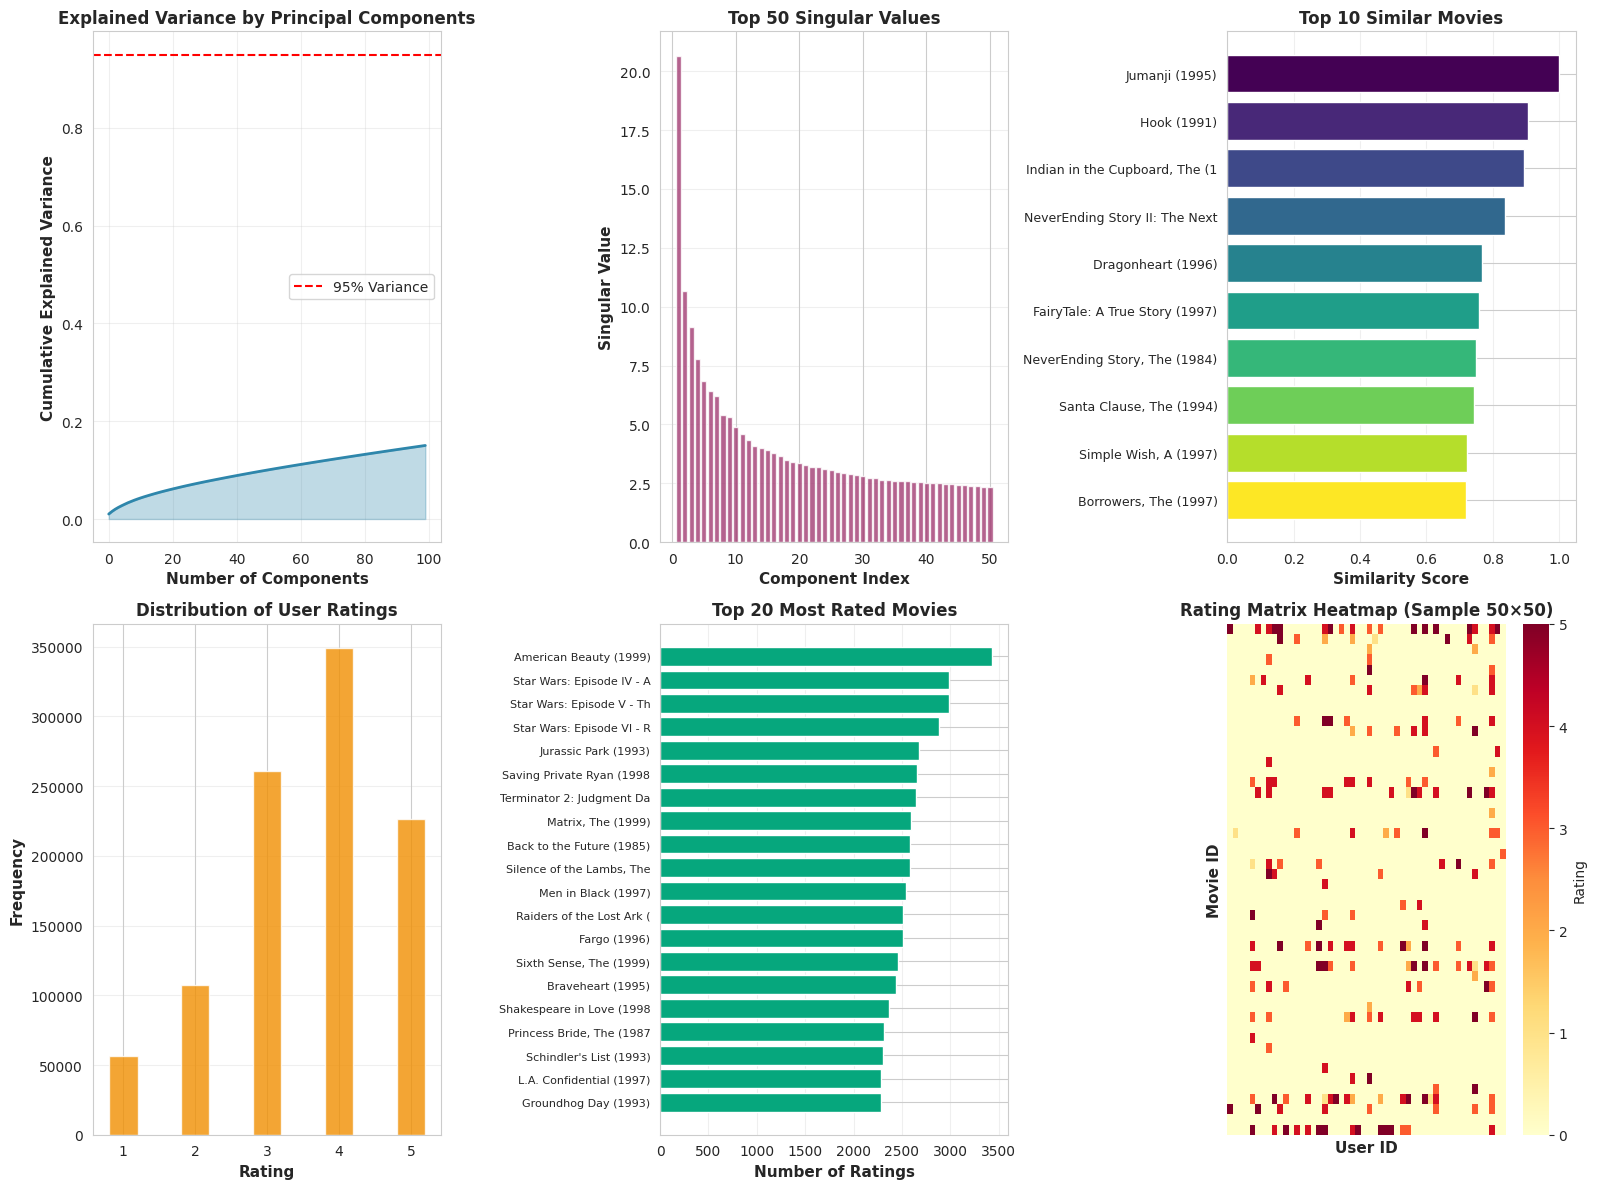

In [11]:
print("\n\nGenerating visualizations...")

fig = plt.figure(figsize=(16, 12))

# 1. Cumulative Explained Variance
ax1 = plt.subplot(2, 3, 1)
cumsum = np.cumsum(S) / np.sum(S)
ax1.plot(cumsum[:100], linewidth=2, color='#2E86AB')
ax1.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
ax1.fill_between(range(len(cumsum[:100])), cumsum[:100], alpha=0.3, color='#2E86AB')
ax1.set_xlabel('Number of Components', fontsize=11, fontweight='bold')
ax1.set_ylabel('Cumulative Explained Variance', fontsize=11, fontweight='bold')
ax1.set_title('Explained Variance by Principal Components', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Top Singular Values
ax2 = plt.subplot(2, 3, 2)
ax2.bar(range(1, 51), S[:50], color='#A23B72', alpha=0.8)
ax2.set_xlabel('Component Index', fontsize=11, fontweight='bold')
ax2.set_ylabel('Singular Value', fontsize=11, fontweight='bold')
ax2.set_title('Top 50 Singular Values', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# 3. Recommendation Similarity Scores
ax3 = plt.subplot(2, 3, 3)
rec_titles = [movieData[movieData.movie_id == idx+1].title.values[0][:30]
              for idx in recommended_indexes]
colors = plt.cm.viridis(np.linspace(0, 1, len(recommended_indexes)))
bars = ax3.barh(range(len(recommended_indexes)),
                 similarity_scores[recommended_indexes], color=colors)
ax3.set_yticks(range(len(recommended_indexes)))
ax3.set_yticklabels(rec_titles, fontsize=9)
ax3.set_xlabel('Similarity Score', fontsize=11, fontweight='bold')
ax3.set_title(f'Top {top_n} Similar Movies', fontsize=12, fontweight='bold')
ax3.invert_yaxis()
ax3.grid(True, alpha=0.3, axis='x')

# 4. Rating Distribution
ax4 = plt.subplot(2, 3, 4)
rating_counts = ratingData['rating'].value_counts().sort_index()
ax4.bar(rating_counts.index, rating_counts.values, color='#F18F01', alpha=0.8, width=0.4)
ax4.set_xlabel('Rating', fontsize=11, fontweight='bold')
ax4.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax4.set_title('Distribution of User Ratings', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# 5. Ratings per Movie (Top 20)
ax5 = plt.subplot(2, 3, 5)
movie_rating_counts = ratingData.groupby('movie_id').size().nlargest(20)
ax5.barh(range(len(movie_rating_counts)), movie_rating_counts.values, color='#06A77D')
ax5.set_yticks(range(len(movie_rating_counts)))
ax5.set_yticklabels([movieData[movieData.movie_id == mid].title.values[0][:25]
                      for mid in movie_rating_counts.index], fontsize=8)
ax5.set_xlabel('Number of Ratings', fontsize=11, fontweight='bold')
ax5.set_title('Top 20 Most Rated Movies', fontsize=12, fontweight='bold')
ax5.invert_yaxis()
ax5.grid(True, alpha=0.3, axis='x')

# 6. Sparsity Heatmap (Sample)
ax6 = plt.subplot(2, 3, 6)
sample_matrix = ratingMatrix[:50, :50]
sns.heatmap(sample_matrix, cmap='YlOrRd', cbar_kws={'label': 'Rating'},
            ax=ax6, xticklabels=False, yticklabels=False)
ax6.set_title('Rating Matrix Heatmap (Sample 50×50)', fontsize=12, fontweight='bold')
ax6.set_xlabel('User ID', fontsize=11, fontweight='bold')
ax6.set_ylabel('Movie ID', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('movie_recommendation_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Visualization saved as 'movie_recommendation_analysis.png'")
plt.show()

In [12]:
print("\n\n" + "="*60)
print("TRAINING RANDOM FOREST MODELS")
print("="*60)

print("\n[RF-1/4] Preparing data for Random Forest...")

# Prepare features from SVD components
X = sliced  # Using SVD reduced features

# Target 1: Predict Rating (Regression)
# Create target based on average rating per movie
y_regression = np.mean(ratingMatrix, axis=1)

# Target 2: Predict High Rating (Classification - Rating >= 3.5)
y_classification = (y_regression >= 3.5).astype(int)

print(f"✓ Features shape: {X.shape}")
print(f"✓ Regression target shape: {y_regression.shape}")
print(f"✓ Classification target distribution: {np.bincount(y_classification)}")

# Split data
X_train, X_test, y_reg_train, y_reg_test = train_test_split(
    X, y_regression, test_size=0.2, random_state=42)

X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(
    X, y_classification, test_size=0.2, random_state=42)

print("\n[RF-2/4] Training Random Forest Regressor (for rating prediction)...")

rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=15,
                                      min_samples_split=5, random_state=42, n_jobs=-1)
rf_regressor.fit(X_train, y_reg_train)

y_reg_pred = rf_regressor.predict(X_test)
mse = mean_squared_error(y_reg_test, y_reg_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_reg_test, y_reg_pred)

print(f"✓ Regressor trained!")
print(f"  - MSE: {mse:.4f}")
print(f"  - RMSE: {rmse:.4f}")
print(f"  - R² Score: {r2:.4f}")

print("\n[RF-3/4] Training Random Forest Classifier (for high rating prediction)...")

rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=15,
                                        min_samples_split=5, random_state=42, n_jobs=-1)
rf_classifier.fit(X_clf_train, y_clf_train)

y_clf_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_clf_test, y_clf_pred)

print(f"✓ Classifier trained!")
print(f"  - Accuracy: {accuracy:.4f}")
print(f"  - Classification Report:\n{classification_report(y_clf_test, y_clf_pred)}")

print("\n[RF-4/4] Extracting feature importance...")

feature_importance_reg = rf_regressor.feature_importances_
feature_importance_clf = rf_classifier.feature_importances_

top_features_reg = np.argsort(feature_importance_reg)[-10:][::-1]
top_features_clf = np.argsort(feature_importance_clf)[-10:][::-1]

print(f"✓ Top 10 important components (Regressor): {top_features_reg}")
print(f"✓ Top 10 important components (Classifier): {top_features_clf}")



TRAINING RANDOM FOREST MODELS

[RF-1/4] Preparing data for Random Forest...
✓ Features shape: (3952, 50)
✓ Regression target shape: (3952,)
✓ Classification target distribution: [3952]

[RF-2/4] Training Random Forest Regressor (for rating prediction)...
✓ Regressor trained!
  - MSE: 0.0014
  - RMSE: 0.0379
  - R² Score: 0.9745

[RF-3/4] Training Random Forest Classifier (for high rating prediction)...
✓ Classifier trained!
  - Accuracy: 1.0000
  - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       791

    accuracy                           1.00       791
   macro avg       1.00      1.00      1.00       791
weighted avg       1.00      1.00      1.00       791


[RF-4/4] Extracting feature importance...
✓ Top 10 important components (Regressor): [ 0  6  9 32 20 16 31 30 23 39]
✓ Top 10 important components (Classifier): [49 48 47 46 45 44 43 42 41 40]


In [14]:
print("\n\n[RF-RECOMMENDATIONS] Using Random Forest for predictions...")

predicted_ratings = rf_regressor.predict(sliced)

# Check if the classifier was trained on a single class
if rf_classifier.n_classes_ == 1:
    # If trained on a single class (likely 0), set high_rating_prob to 0
    high_rating_prob = np.zeros(sliced.shape[0])
    print("Note: Classifier trained on a single class (likely low ratings). Setting high rating probability to 0 for all movies.")
else:
    # Otherwise, get the probability of the positive class (class 1)
    high_rating_prob = rf_classifier.predict_proba(sliced)[:, 1]


# Get top recommended movies based on RF predictions
rf_top_n = 10
rf_rec_indexes = np.argsort(-predicted_ratings)[:rf_top_n]

print(f"\n[TOP {rf_top_n} RECOMMENDATIONS BY RANDOM FOREST]")
print("="*60)

rf_recommendations_df = pd.DataFrame({
    'Movie ID': rf_rec_indexes + 1,
    'Title': [movieData[movieData.movie_id == idx+1].title.values[0]
              for idx in rf_rec_indexes],
    'Predicted Rating': predicted_ratings[rf_rec_indexes],
    'High Rating Probability': high_rating_prob[rf_rec_indexes]
})

print(rf_recommendations_df.to_string(index=False))



[RF-RECOMMENDATIONS] Using Random Forest for predictions...
Note: Classifier trained on a single class (likely low ratings). Setting high rating probability to 0 for all movies.

[TOP 10 RECOMMENDATIONS BY RANDOM FOREST]
 Movie ID                                                 Title  Predicted Rating  High Rating Probability
      260             Star Wars: Episode IV - A New Hope (1977)          2.039972                      0.0
     1196 Star Wars: Episode V - The Empire Strikes Back (1980)          1.990412                      0.0
     1210     Star Wars: Episode VI - Return of the Jedi (1983)          1.861708                      0.0
     2028                            Saving Private Ryan (1998)          1.790683                      0.0
     2571                                    Matrix, The (1999)          1.742992                      0.0
     1198                        Raiders of the Lost Ark (1981)          1.708235                      0.0
      589                   



Generating enhanced visualizations...
✓ Visualization saved as 'movie_recommendation_analysis_with_rf.png'


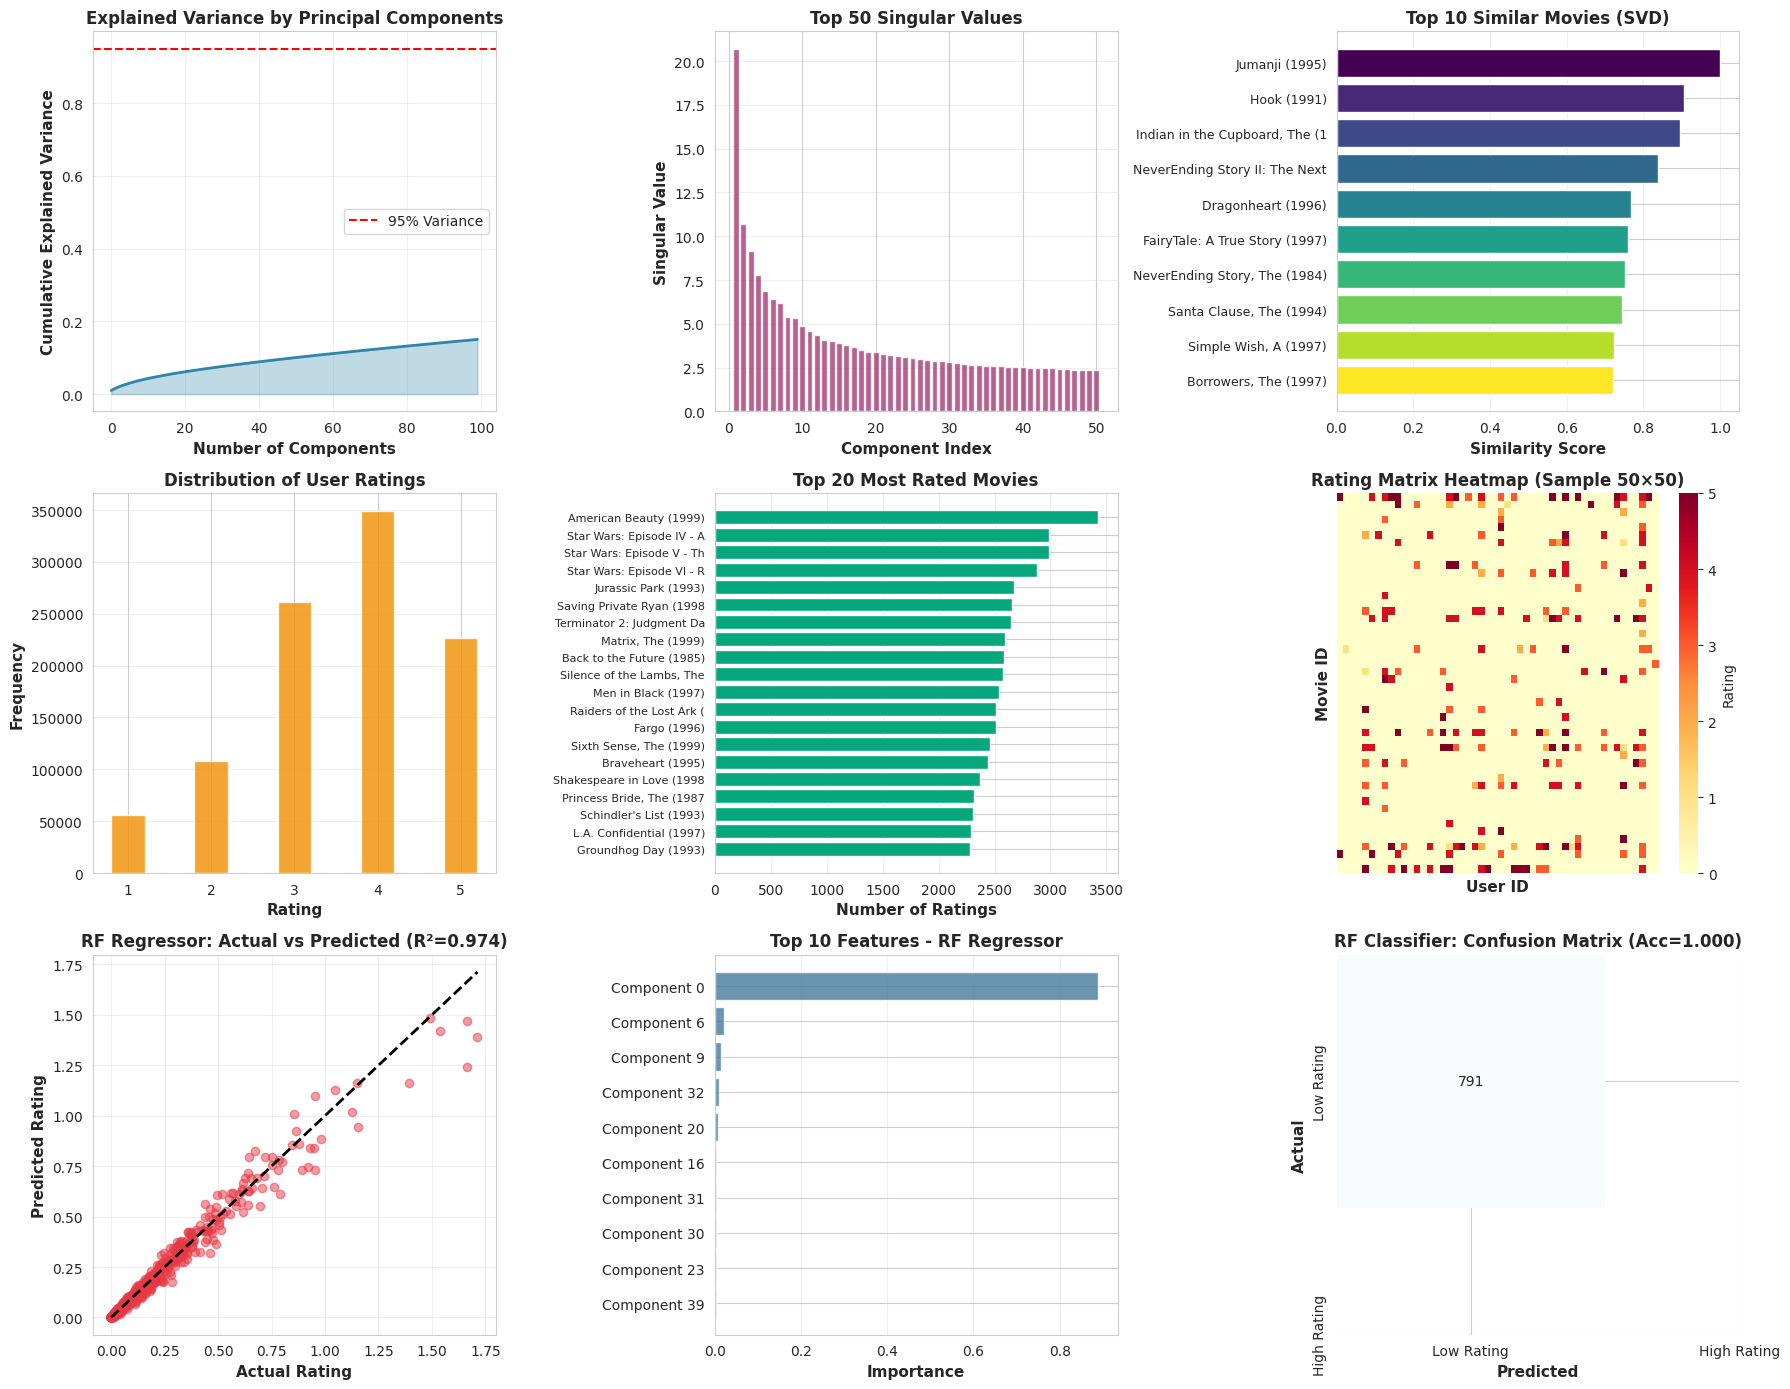


ANALYSIS COMPLETE!


In [ ]:
print("\n\nGenerating enhanced visualizations...")

fig = plt.figure(figsize=(18, 14))



# 7. RF Regressor - Actual vs Predicted
ax7 = plt.subplot(3, 3, 7)
ax7.scatter(y_reg_test, y_reg_pred, alpha=0.5, color='#E63946')
ax7.plot([y_reg_test.min(), y_reg_test.max()],
         [y_reg_test.min(), y_reg_test.max()], 'k--', lw=2)
ax7.set_xlabel('Actual Rating', fontsize=11, fontweight='bold')
ax7.set_ylabel('Predicted Rating', fontsize=11, fontweight='bold')
ax7.set_title(f'RF Regressor: Actual vs Predicted (R²={r2:.3f})', fontsize=12, fontweight='bold')
ax7.grid(True, alpha=0.3)

# 8. Feature Importance - Regressor
ax8 = plt.subplot(3, 3, 8)
ax8.barh(range(10), feature_importance_reg[top_features_reg], color='#457B9D', alpha=0.8)
ax8.set_yticks(range(10))
ax8.set_yticklabels([f'Component {i}' for i in top_features_reg], fontsize=10)
ax8.set_xlabel('Importance', fontsize=11, fontweight='bold')
ax8.set_title('Top 10 Features - RF Regressor', fontsize=12, fontweight='bold')
ax8.invert_yaxis()
ax8.grid(True, alpha=0.3, axis='x')

# 9. RF Classifier - Confusion Matrix
ax9 = plt.subplot(3, 3, 9)
cm = confusion_matrix(y_clf_test, y_clf_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax9, cbar=False,
            xticklabels=['Low Rating', 'High Rating'],
            yticklabels=['Low Rating', 'High Rating'])
ax9.set_ylabel('Actual', fontsize=11, fontweight='bold')
ax9.set_xlabel('Predicted', fontsize=11, fontweight='bold')
ax9.set_title(f'RF Classifier: Confusion Matrix (Acc={accuracy:.3f})', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('movie_recommendation_analysis_with_rf.png', dpi=300, bbox_inches='tight')
print("✓ Visualization saved as 'movie_recommendation_analysis_with_rf.png'")
plt.show()

print("\n" + "="*60)
print("ANALYSIS COMPLETE!")
print("="*60)